## DATA 512- Comparitive Analysis
by Vritesh Gera

# Analysis of Smoke Estimate and Healthcare data

# 1. Readiing the Smoke Estimate data from the previous notebook

Reading back the Klamath Falls data filtered and saved in DATA 512 Wildfire Part 1.ipynb 

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

file_path = "wildfires_klamath_falls.json"
with open(file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

print(len(loaded_data))

75413


These steps are copied from the previous notebook as I want to generate the smoke estimate again

In [4]:
#Declarng a variable which takes in the data from the previous step
smoke_list = loaded_data
assigned_fire_type_weights = {
    'Likely Wildfire': 15,
    'Wildfire': 20,
    'Prescribed Wildfire': 12.5,
    'Unknown - Likely Wildfire': 20,
    'Unknown - Likely Prescribed Wildfire': 12.5
}
for wf_feature in tqdm(smoke_list):
    try:
        type_weight = wf_feature['Assigned_Fire_Type']
        fire_area = wf_feature['GIS_Hectares']/258.998811 #to convert the area to miles^2 
        fire_distance = wf_feature['distance']
    except:
        print("There is a missing attribute")
    if 'Assigned_Fire_Type' in wf_feature:
        if type_weight in assigned_fire_type_weights:
            smoke_estimate = (fire_area/fire_distance) * assigned_fire_type_weights[type_weight]
        else:
            smoke_estimate = fire_area/fire_distance
        wf_feature['smoke_estimate'] = smoke_estimate

# We will extract the features that are required for our analysis and save it in a list: res_temp
res_temp = []
for wf_feature in tqdm(smoke_list):
    temp_feature = {}
    temp_feature['USGS_Assigned_ID'] = wf_feature['USGS_Assigned_ID']
    temp_feature['Assigned_Fire_Type'] = wf_feature['Assigned_Fire_Type']
    temp_feature['Fire_Year'] = wf_feature['Fire_Year']
    temp_feature['GIS_Hectares'] = wf_feature['GIS_Hectares']
    temp_feature['Listed_Fire_Names'] = wf_feature['Listed_Fire_Names']
    temp_feature['distance'] = wf_feature['distance']
    temp_feature['smoke_estimate'] = wf_feature['smoke_estimate']
    res_temp.append(temp_feature)
    
# convert res_temp to a dataframe
df_temp = pd.DataFrame(res_temp)
#df_temp.head()

#Assigning this temperary data to the final dataset which will be used for further reflections
df_final = df_temp

df_final = df_final[df_final['smoke_estimate'] > 2]
df_final = df_final.groupby("Fire_Year")["smoke_estimate"].mean()
#df_final.head()
df_final = df_final.reset_index()

df_final = df_final.reset_index()
df_final.head()

100%|██████████| 75413/75413 [00:00<00:00, 1019184.88it/s]


,index,Fire_Year,smoke_estimate
0,0,1963,3.926883
1,1,1964,4.508538
2,2,1965,3.138808
3,3,1966,4.516185
4,4,1967,2.395096


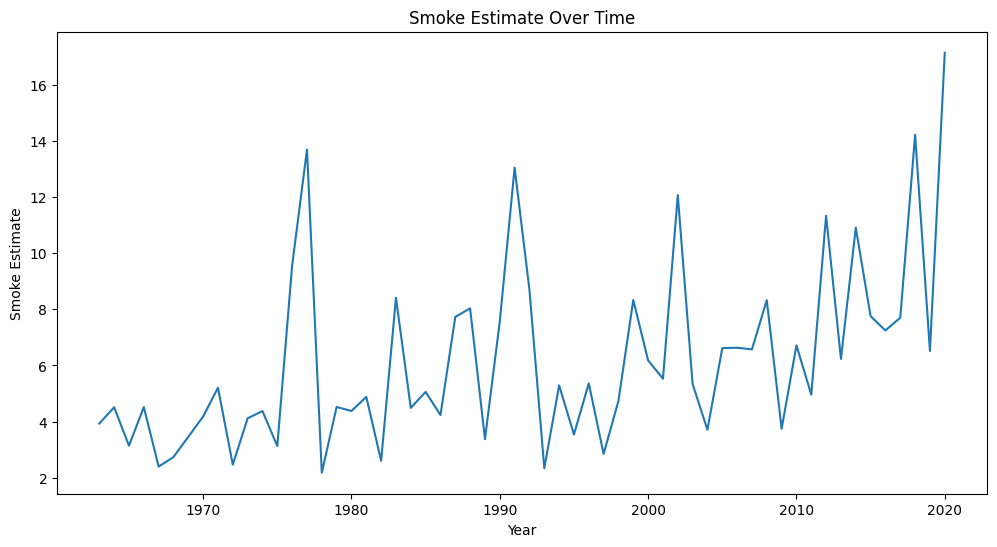

In [5]:
#Plotting the smoke estimate
df_final['Fire_Year'] = pd.to_datetime(df_final['Fire_Year'], format='%Y')
df_final.set_index('Fire_Year', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df_final['smoke_estimate'])
plt.title('Smoke Estimate Over Time')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()

# 2.Reading and Preprocessing the hospital data

Now that we have extracted the smoke estimate from the previous analysis, we will read in the hospital dataset which we have acquired. The source of the hospital dataset is: https://www.oregon.gov/oha/hpa/analytics/pages/hospital-reporting.aspx

In [6]:
# Specify the path to your Excel file
excel_file_path = 'Hospital_Dataset.xlsx'

# Read the Excel file into a Pandas DataFrame
df_hospital = pd.read_excel(excel_file_path,header=0)

In [7]:
#Let's look at the hospital data now
df_hospital.head()

,AHA ID,Hospital Name,Hospital Short Name,Type,Critical Access,Month,Quarter,Year,Available Beds,Licensed Beds,...,Gross Patient Accounts Receivable (Medicare),Gross Patient Accounts Receivable (Medicaid),Gross Patient Accounts Receivable (Self Pay),Gross Patient Accounts Receivable (Commercial),Gross Patient Accounts Receivable (Others),Gross Patient Accounts Receivable,Uncompensated Care,Inpatient Discharges,Total Operating Revenue,Total Revenue
0,6920510,Adventist Health Portland,Adventist Med Ctr,DRG,False,1,1,2023,248,302,...,86426917,44875176,5232632,42593228.0,10692322,189820274,1866636,640,28001822,30075976
1,6920780,Adventist Health Tillamook,Adventist Tillamook Reg Med Ctr,A,True,1,1,2023,25,49,...,10365488,8149741,2452984,3932332.0,7237012,32137559,80811,96,9093300,10562167
2,6920025,Asante Ashland Community Hospital,Asante Ashland Comm Hosp,B,False,1,1,2023,38,49,...,8715970,8685619,500136,10300860.0,11814635,40017220,294019,107,6165494,6495368
3,6920280,Asante Rogue Regional Medical Center,Asante Rogue Med Ctr,DRG,False,1,1,2023,343,378,...,115211987,95894965,8415570,109684502.0,151326438,480533462,2453095,1334,67319061,70468249
4,6920005,Asante Three Rivers Medical Center,Asante Three Rivers Med Ctr,DRG,False,1,1,2023,122,125,...,38164333,43104272,4173728,32008482.0,67481049,184931864,1127429,531,26137502,27224638


Now we will filter out the data for the hospital in Klamath Falls i.e. Sky Lakes Medical Center. After getting the data, we will group available beds per year to find the total number of beds which are available per year.

In [8]:
#Preprocessing data
df_hospital['Hospital Name'] = df_hospital['Hospital Name'].str.strip()
df_hospital_klamath = df_hospital[df_hospital['Hospital Name'] =='Sky Lakes Medical Center']
# Sum the available beds for every year
available_beds_per_year = df_hospital_klamath.groupby('Year')['Available Beds'].sum()

In [9]:
#Converting series to dataframe
df_available_beds_per_year = available_beds_per_year.reset_index()
df_available_beds_per_year.head(5)

,Year,Available Beds
0,2007,1547
1,2008,1355
2,2009,1200
3,2010,1200
4,2011,1200


# Plotting Visualizations 

Now we will plot the trend of the total available hospital beds in Klamath Falls from 2008 to the present day.

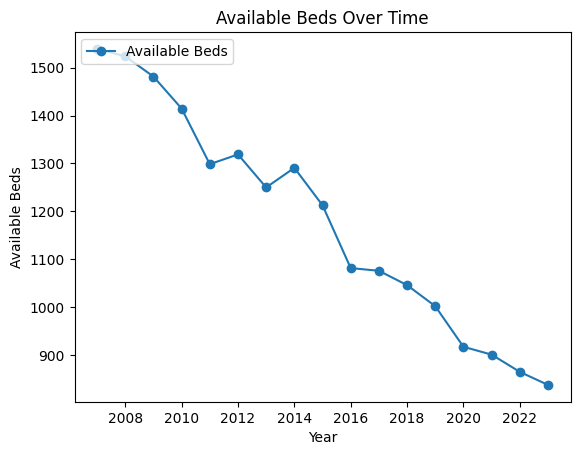

In [10]:
#Plot the graph of available beds per year
plt.plot(df_available_beds_per_year['Year'], df_available_beds_per_year['Available Beds'], label='Available Beds', marker='o')
# Set labels and title
plt.xlabel('Year')
plt.ylabel('Available Beds')
plt.title('Available Beds Over Time')

# Show legend
plt.legend(loc='upper left')
plt.show()

We notice that the availability of beds is constantly decreasing with time. Our smoke estimate also depicts an uptrend, which goes on to show that as smoke and pollution increased in Klamath Falls, the number of people getting hospitalized become more and more.
However, it should be noted that multiple possible factors can be responsible for the decrease in the availability of hospital beds like repair work, increase in hospitalization due to other diseases, etc. Hence, we cannot just blame the wildfires for this downtrend in bed availability.

After this, we will try to study how the total revenue made by the hospital has changed over the years. Our hypothesis is that as the number of patients are clearly increasing, the money made by the hospitals would also increase.

In [10]:
# Sum the Revenue for every year
Total_Revenue_per_year = df_hospital_klamath.groupby('Year')['Total Revenue'].sum()
df_total_Revenue_per_year = Total_Revenue_per_year.reset_index()

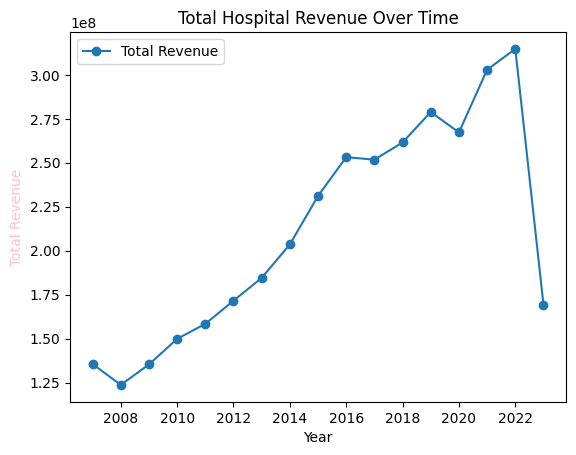

In [62]:
# Plotting available beds
plt.plot(df_total_Revenue_per_year['Year'], df_total_Revenue_per_year['Total Revenue'], label='Total Revenue', marker='o')
# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Revenue', color='pink')
plt.title('Total Hospital Revenue Over Time')

# Show legend
plt.legend(loc='upper left')
plt.show()

Here we can see that our hypothesis that the hospital revenues would increase is correct. A sudden drop towards the end is because we do not have the complete data of 2023 till now and hence it is not the correct depiction of the money made by the hospital in that year.
Again, it should be noted that multiple possible factors can be responsible for the increase in the revenue of hospitals like an increase in the price of healthcare, expansion of facilities, etc. Hence, we cannot just blame the wildfires for this downtrend in bed availability.


# Predicting future values

Now we will be reading the file having the future data for smoke estimate for 25 years into the future. This file was created and saved in the notebook DATA 512 Wildfire Part 1.

In [49]:
file_path = "future_smoke_estimate.json"
with open(file_path, 'r') as json_file:
    future_smoke_estimate = json.load(json_file)

print(len(future_smoke_estimate))

78


We will create a Linear regression model which will predict the trend of 1) hospital beds 2) hospital revenue based on just 1 factor, the smoke estimate.

In [42]:
#First step would be to merge the available beds with the smoke estimate dataframe based on the Year column in both the tables
df_available_beds_per_year['Year'] = pd.to_datetime(df_available_beds_per_year['Year'], format='%Y')
merged_df = pd.merge(df_available_beds_per_year, df_final, left_on='Year', right_on='Fire_Year', how='inner')

# Drop the duplicate 'Year' column from the merged dataframe
merged_df = merged_df.drop('Fire_Year', axis=1)

# Display the merged dataframe
print(merged_df)

         Year  Available Beds  smoke_estimate
0  2007-01-01     1554.189566        6.572794
1  2008-01-01     1515.854606        8.323582
2  2009-01-01     1499.167915        3.742342
3  2010-01-01     1446.149188        6.713713
4  2011-01-01     1339.817256        4.957847
5  2012-01-01     1254.141170       11.338006
6  2013-01-01     1359.123005        6.231877
7  2014-01-01     1246.451461       10.911578
8  2015-01-01     1152.837976        7.755044
9  2016-01-01     1129.073748        7.246709
10 2017-01-01     1139.027886        7.702858
11 2018-01-01      960.502814       14.219385
12 2019-01-01     1010.810101        6.516058
13 2020-01-01      949.960370       17.146030


In [43]:
# Create and fit the linear regression model
from sklearn.linear_model import LinearRegression
X = merged_df['smoke_estimate'].values.reshape(-1, 1)
y = merged_df['Available Beds'].values
model = LinearRegression()
model.fit(X,y)


LinearRegression()

In [50]:
# Convert dictionary to DataFrame
df_future_smoke = pd.DataFrame(list(future_smoke_estimate.items()), columns=['Year', 'Value'])
df_future_smoke = df_future_smoke.tail(25)
# Display the DataFrame
print(df_future_smoke)

    Year      Value
53  2024   6.209731
54  2025  13.178257
55  2026   8.328400
56  2027  12.214500
57  2028   8.315948
58  2029  12.327749
59  2030   7.109178
60  2031  12.371961
61  2032   7.609766
62  2033  11.794223
63  2034   7.915419
64  2035  11.996988
65  2036   7.519546
66  2037  11.924615
67  2038   7.587534
68  2039  11.589979
69  2040   7.703153
70  2041  11.578178
71  2042   7.601796
72  2043  11.565760
73  2044   7.631155
74  2045  11.377580
75  2046   7.679679
76  2047  11.301904
77  2048   7.646342


In [51]:
# Make predictions using the model
predictions_hospital_beds = model.predict(df_future_smoke['Value'].values.reshape(-1,1))
predictions_hospital_beds

array([1335.98898076, 1089.66692435, 1261.09870496, 1123.73364041,
       1261.53885815, 1119.73053909, 1304.19550222, 1118.16773368,
       1286.50082485, 1138.58947894, 1275.69665341, 1131.4221923 ,
       1289.68990659, 1133.98042222, 1287.28666846, 1145.80906228,
       1283.19979107, 1146.22621041, 1286.78256699, 1146.66516153,
       1285.74476193, 1153.31690922, 1284.02957725, 1155.99190107,
       1285.20796426])

In [53]:
# Create 'Year' column starting from 2024 to 2048
years = pd.Series(range(2024, 2049), name='Year')

# Create DataFrame
df_future_beds = pd.DataFrame({'Year': years, 'Hospital Beds Available': predictions_hospital_beds})

# Display the DataFrame
print(df_future_beds)

    Year  Hospital Beds Available
0   2024              1335.988981
1   2025              1089.666924
2   2026              1261.098705
3   2027              1123.733640
4   2028              1261.538858
5   2029              1119.730539
6   2030              1304.195502
7   2031              1118.167734
8   2032              1286.500825
9   2033              1138.589479
10  2034              1275.696653
11  2035              1131.422192
12  2036              1289.689907
13  2037              1133.980422
14  2038              1287.286668
15  2039              1145.809062
16  2040              1283.199791
17  2041              1146.226210
18  2042              1286.782567
19  2043              1146.665162
20  2044              1285.744762
21  2045              1153.316909
22  2046              1284.029577
23  2047              1155.991901
24  2048              1285.207964


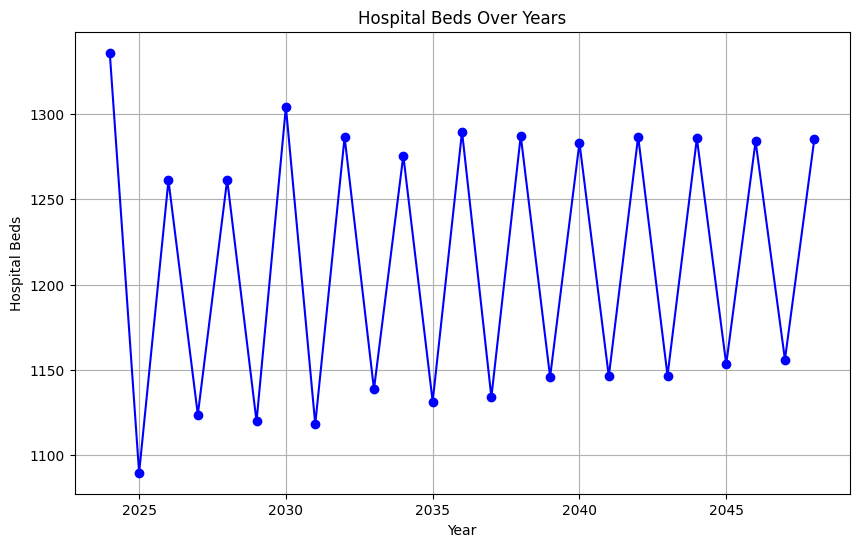

In [54]:
#Now we will plot the graph
plt.figure(figsize=(10, 6))
plt.plot(df_future_beds['Year'], df_future_beds['Hospital Beds Available'], marker='o', linestyle='-', color='b')
plt.title('Hospital Beds Over Years')
plt.xlabel('Year')
plt.ylabel('Hospital Beds')
plt.grid(True)
plt.show()

Here we can see that there is a zig-zag trend of hospital beds which does not really tell us much. We can conclude that just the smoke estimate cannot be used to predict the future of bed availabilty in hospitals and we would need many more variables to predict this precisely.

Now we will work on the Total Hospital Revenue future value predictions based on smoke estimate

In [55]:
df_total_Revenue_per_year.head()

,Year,Total Revenue
0,2007,135672075
1,2008,123766977
2,2009,135381530
3,2010,149939915
4,2011,158452133


In [56]:
#First step would be to merge the available beds with the smoke estimate dataframe based on the Year column in both the tables
df_total_Revenue_per_year['Year'] = pd.to_datetime(df_total_Revenue_per_year['Year'], format='%Y')
merged_revenue_df = pd.merge(df_total_Revenue_per_year, df_final, left_on='Year', right_on='Fire_Year', how='inner')

# Drop the duplicate 'Year' column from the merged dataframe
merged_revenue_df = merged_revenue_df.drop('Fire_Year', axis=1)

# Display the merged dataframe
print(merged_revenue_df)

         Year  Total Revenue  smoke_estimate
0  2007-01-01      135672075        6.572794
1  2008-01-01      123766977        8.323582
2  2009-01-01      135381530        3.742342
3  2010-01-01      149939915        6.713713
4  2011-01-01      158452133        4.957847
5  2012-01-01      171617082       11.338006
6  2013-01-01      184585074        6.231877
7  2014-01-01      203625241       10.911578
8  2015-01-01      231143295        7.755044
9  2016-01-01      253201733        7.246709
10 2017-01-01      251767072        7.702858
11 2018-01-01      261564015       14.219385
12 2019-01-01      278849564        6.516058
13 2020-01-01      267273103       17.146030


In [57]:
# Create and fit the linear regression model

X = merged_revenue_df['smoke_estimate'].values.reshape(-1, 1)
y = merged_revenue_df['Total Revenue'].values
model_2 = LinearRegression()
model_2.fit(X,y)

LinearRegression()

In [58]:
# Make predictions using the model
predictions_hospital_revenue = model_2.predict(df_future_smoke['Value'].values.reshape(-1,1))
predictions_hospital_revenue

array([1.83426913e+08, 2.34735016e+08, 1.99026320e+08, 2.27639027e+08,
       1.98934637e+08, 2.28472861e+08, 1.90049394e+08, 2.28798388e+08,
       1.93735139e+08, 2.24544603e+08, 1.95985613e+08, 2.26037526e+08,
       1.93070863e+08, 2.25504655e+08, 1.93571450e+08, 2.23040787e+08,
       1.94422734e+08, 2.22953896e+08, 1.93676453e+08, 2.22862464e+08,
       1.93892624e+08, 2.21476926e+08, 1.94249892e+08, 2.20919734e+08,
       1.94004438e+08])

In [59]:
# Create DataFrame
df_future_revenue = pd.DataFrame({'Year': years, 'Future Hospital Revenue': predictions_hospital_revenue})

# Display the DataFrame
print(df_future_revenue)

    Year  Future Hospital Revenue
0   2024             1.834269e+08
1   2025             2.347350e+08
2   2026             1.990263e+08
3   2027             2.276390e+08
4   2028             1.989346e+08
5   2029             2.284729e+08
6   2030             1.900494e+08
7   2031             2.287984e+08
8   2032             1.937351e+08
9   2033             2.245446e+08
10  2034             1.959856e+08
11  2035             2.260375e+08
12  2036             1.930709e+08
13  2037             2.255047e+08
14  2038             1.935715e+08
15  2039             2.230408e+08
16  2040             1.944227e+08
17  2041             2.229539e+08
18  2042             1.936765e+08
19  2043             2.228625e+08
20  2044             1.938926e+08
21  2045             2.214769e+08
22  2046             1.942499e+08
23  2047             2.209197e+08
24  2048             1.940044e+08


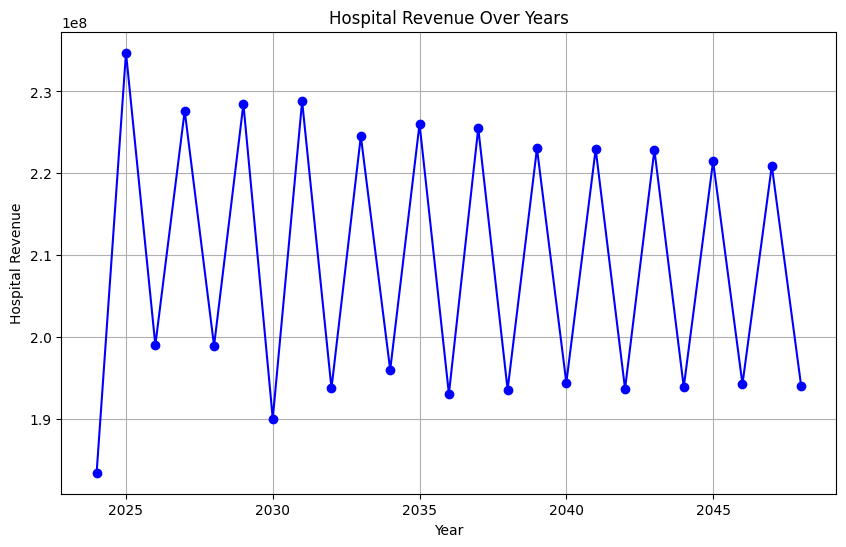

In [60]:
#Now we will plot the graph
plt.figure(figsize=(10, 6))
plt.plot(df_future_revenue['Year'], df_future_revenue['Future Hospital Revenue'], marker='o', linestyle='-', color='b')
plt.title('Hospital Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Hospital Revenue')
plt.grid(True)
plt.show()

Here we can see that there is a zig-zag trend of hospital revenue which does not really tell us much. We can conclude that just the smoke estimate cannot be used to predict the future of hospital revenue and we would need many more variables to predict this precisely.